In [1]:
import pandas as pd
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Calculate_Word_Count_Total_Wait_Time.csv')
df.describe()

,Age,Word_Count_CTD,Total_Wait_Time_CTD,Word_Count_PFT,Total_Wait_Time_PFT,Word_Count_SFT,Total_Wait_Time_SFT,Converted-MMSE
count,157.00000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,69.000000
mean,65.77707,157.433121,7.917197,32.694268,26.509554,49.292994,18.254777,27.362319
std,12.29634,91.043120,8.103467,15.931610,10.884368,21.727998,9.684712,2.467262
min,23.00000,12.000000,0.000000,8.000000,4.000000,16.000000,1.000000,19.000000
25%,62.00000,90.000000,2.000000,21.000000,18.000000,33.000000,12.000000,27.000000
50%,66.00000,135.000000,5.000000,30.000000,26.000000,45.000000,17.000000,28.000000
75%,72.00000,200.000000,11.000000,41.000000,35.000000,61.000000,24.000000,29.000000
max,94.00000,461.000000,39.000000,89.000000,51.000000,120.000000,46.000000,30.000000


## Analyze data

In [3]:
# Get a overview of data types
df_info = { "data_types": df.dtypes }
df_info

{'data_types': Record-ID               object
 TrainOrDev              object
 Class                   object
 Gender                  object
 Age                    float64
 Word_Count_CTD         float64
 Total_Wait_Time_CTD    float64
 Word_Count_PFT         float64
 Total_Wait_Time_PFT    float64
 Word_Count_SFT         float64
 Total_Wait_Time_SFT    float64
 Converted-MMSE         float64
 dtype: object}

In [4]:
# Select numerical columns for correlation analysis
numeric_columns = df.select_dtypes(include = ['float64']).columns
correlation_matrix = df[numeric_columns].corr()

# Correlate numerical columns with Converted-MMSE
mmse_correlation = correlation_matrix['Converted-MMSE'].sort_values(ascending = False)
mmse_correlation

Converted-MMSE         1.000000
Word_Count_CTD         0.194882
Word_Count_SFT         0.004747
Total_Wait_Time_PFT   -0.176075
Word_Count_PFT        -0.231698
Total_Wait_Time_SFT   -0.284651
Age                   -0.335210
Total_Wait_Time_CTD   -0.369492
Name: Converted-MMSE, dtype: float64

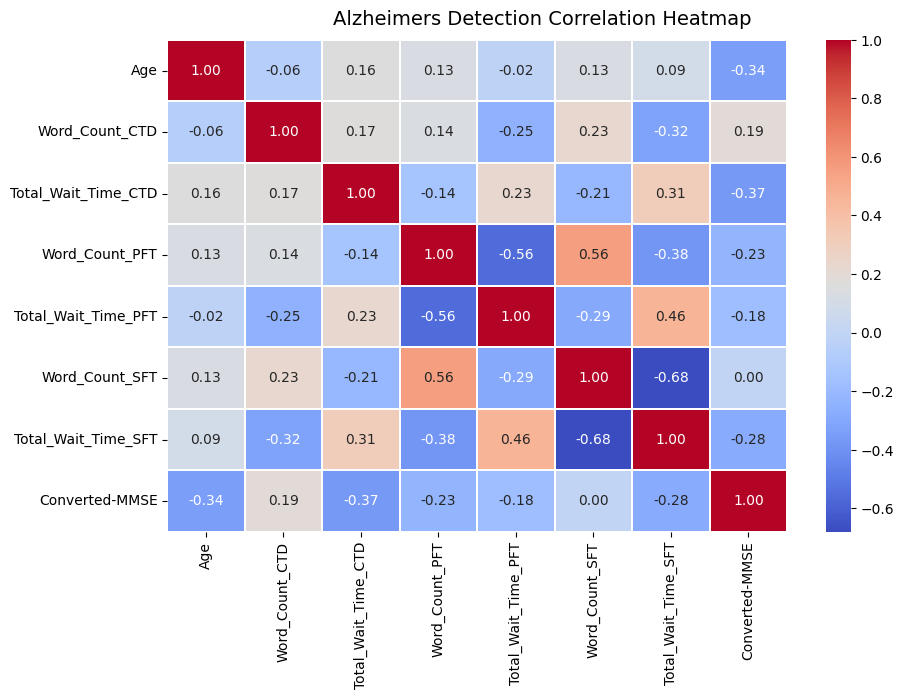

In [5]:
# Pair-wise Correlation Matrix Heatmap
f, ax = plt.subplots(figsize = (10, 6))
corr = df.corr(numeric_only = True)
hm = sns.heatmap(round(corr, 2), annot = True, ax = ax, cmap = "coolwarm", fmt = '.2f', linewidths = .05)
f.subplots_adjust(top = 0.93)
t = f.suptitle('Alzheimers Detection Correlation Heatmap', fontsize = 14)

## Data preparation

In [6]:
# Select features with significant correlations
features = ['Word_Count_PFT', 'Total_Wait_Time_PFT', 'Word_Count_SFT', 'Total_Wait_Time_SFT']

# Selct data without missing values (for training)
train_data = df.dropna(subset = ['Converted-MMSE'])
X_train = train_data[features]
y_train = train_data['Converted-MMSE']

# Select missing value for prediction
missing_data = df[df['Converted-MMSE'].isnull()]
X_missing = missing_data[features]

# Train-Test-Split
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size = .2, random_state = 42)

# Train model
rf_model = RandomForestRegressor(random_state = 42, n_estimators = 100)
rf_model.fit(X_train_split, y_train_split)

# Evaluate model
y_pred = rf_model.predict(X_test_split)
rmse = sqrt(mean_squared_error(y_test_split, y_pred)) 

# Predict missing values
missing_predictions = rf_model.predict(X_missing)

# Show RMSE and impute missing values
rmse, missing_predictions[:5]

(1.6387037560218136, array([25.78, 27.67, 27.78, 27.5 , 28.62]))

In [7]:
# Be sure that indices are correct
missing_indices = df[df['Converted-MMSE'].isnull()].index

# Replace missing values with predicted values
df.loc[missing_indices, 'Converted-MMSE'] = missing_predictions.round().astype(int)

<Axes: ylabel='Converted-MMSE'>

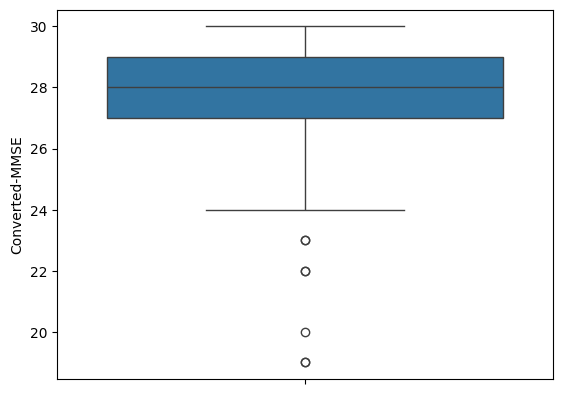

In [8]:
# Boxplot
sns.boxplot(data = df['Converted-MMSE'])

<Axes: ylabel='Converted-MMSE'>

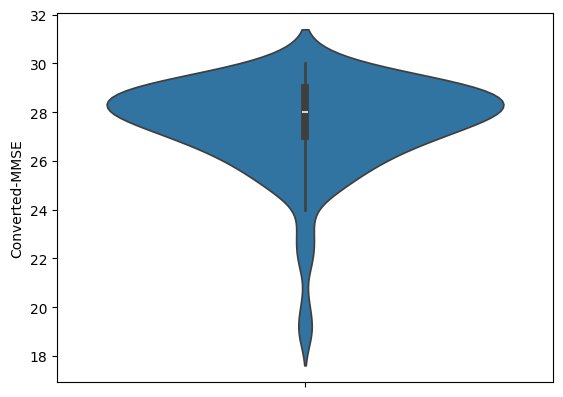

In [9]:
# Violinplot
sns.violinplot(data = df['Converted-MMSE'])

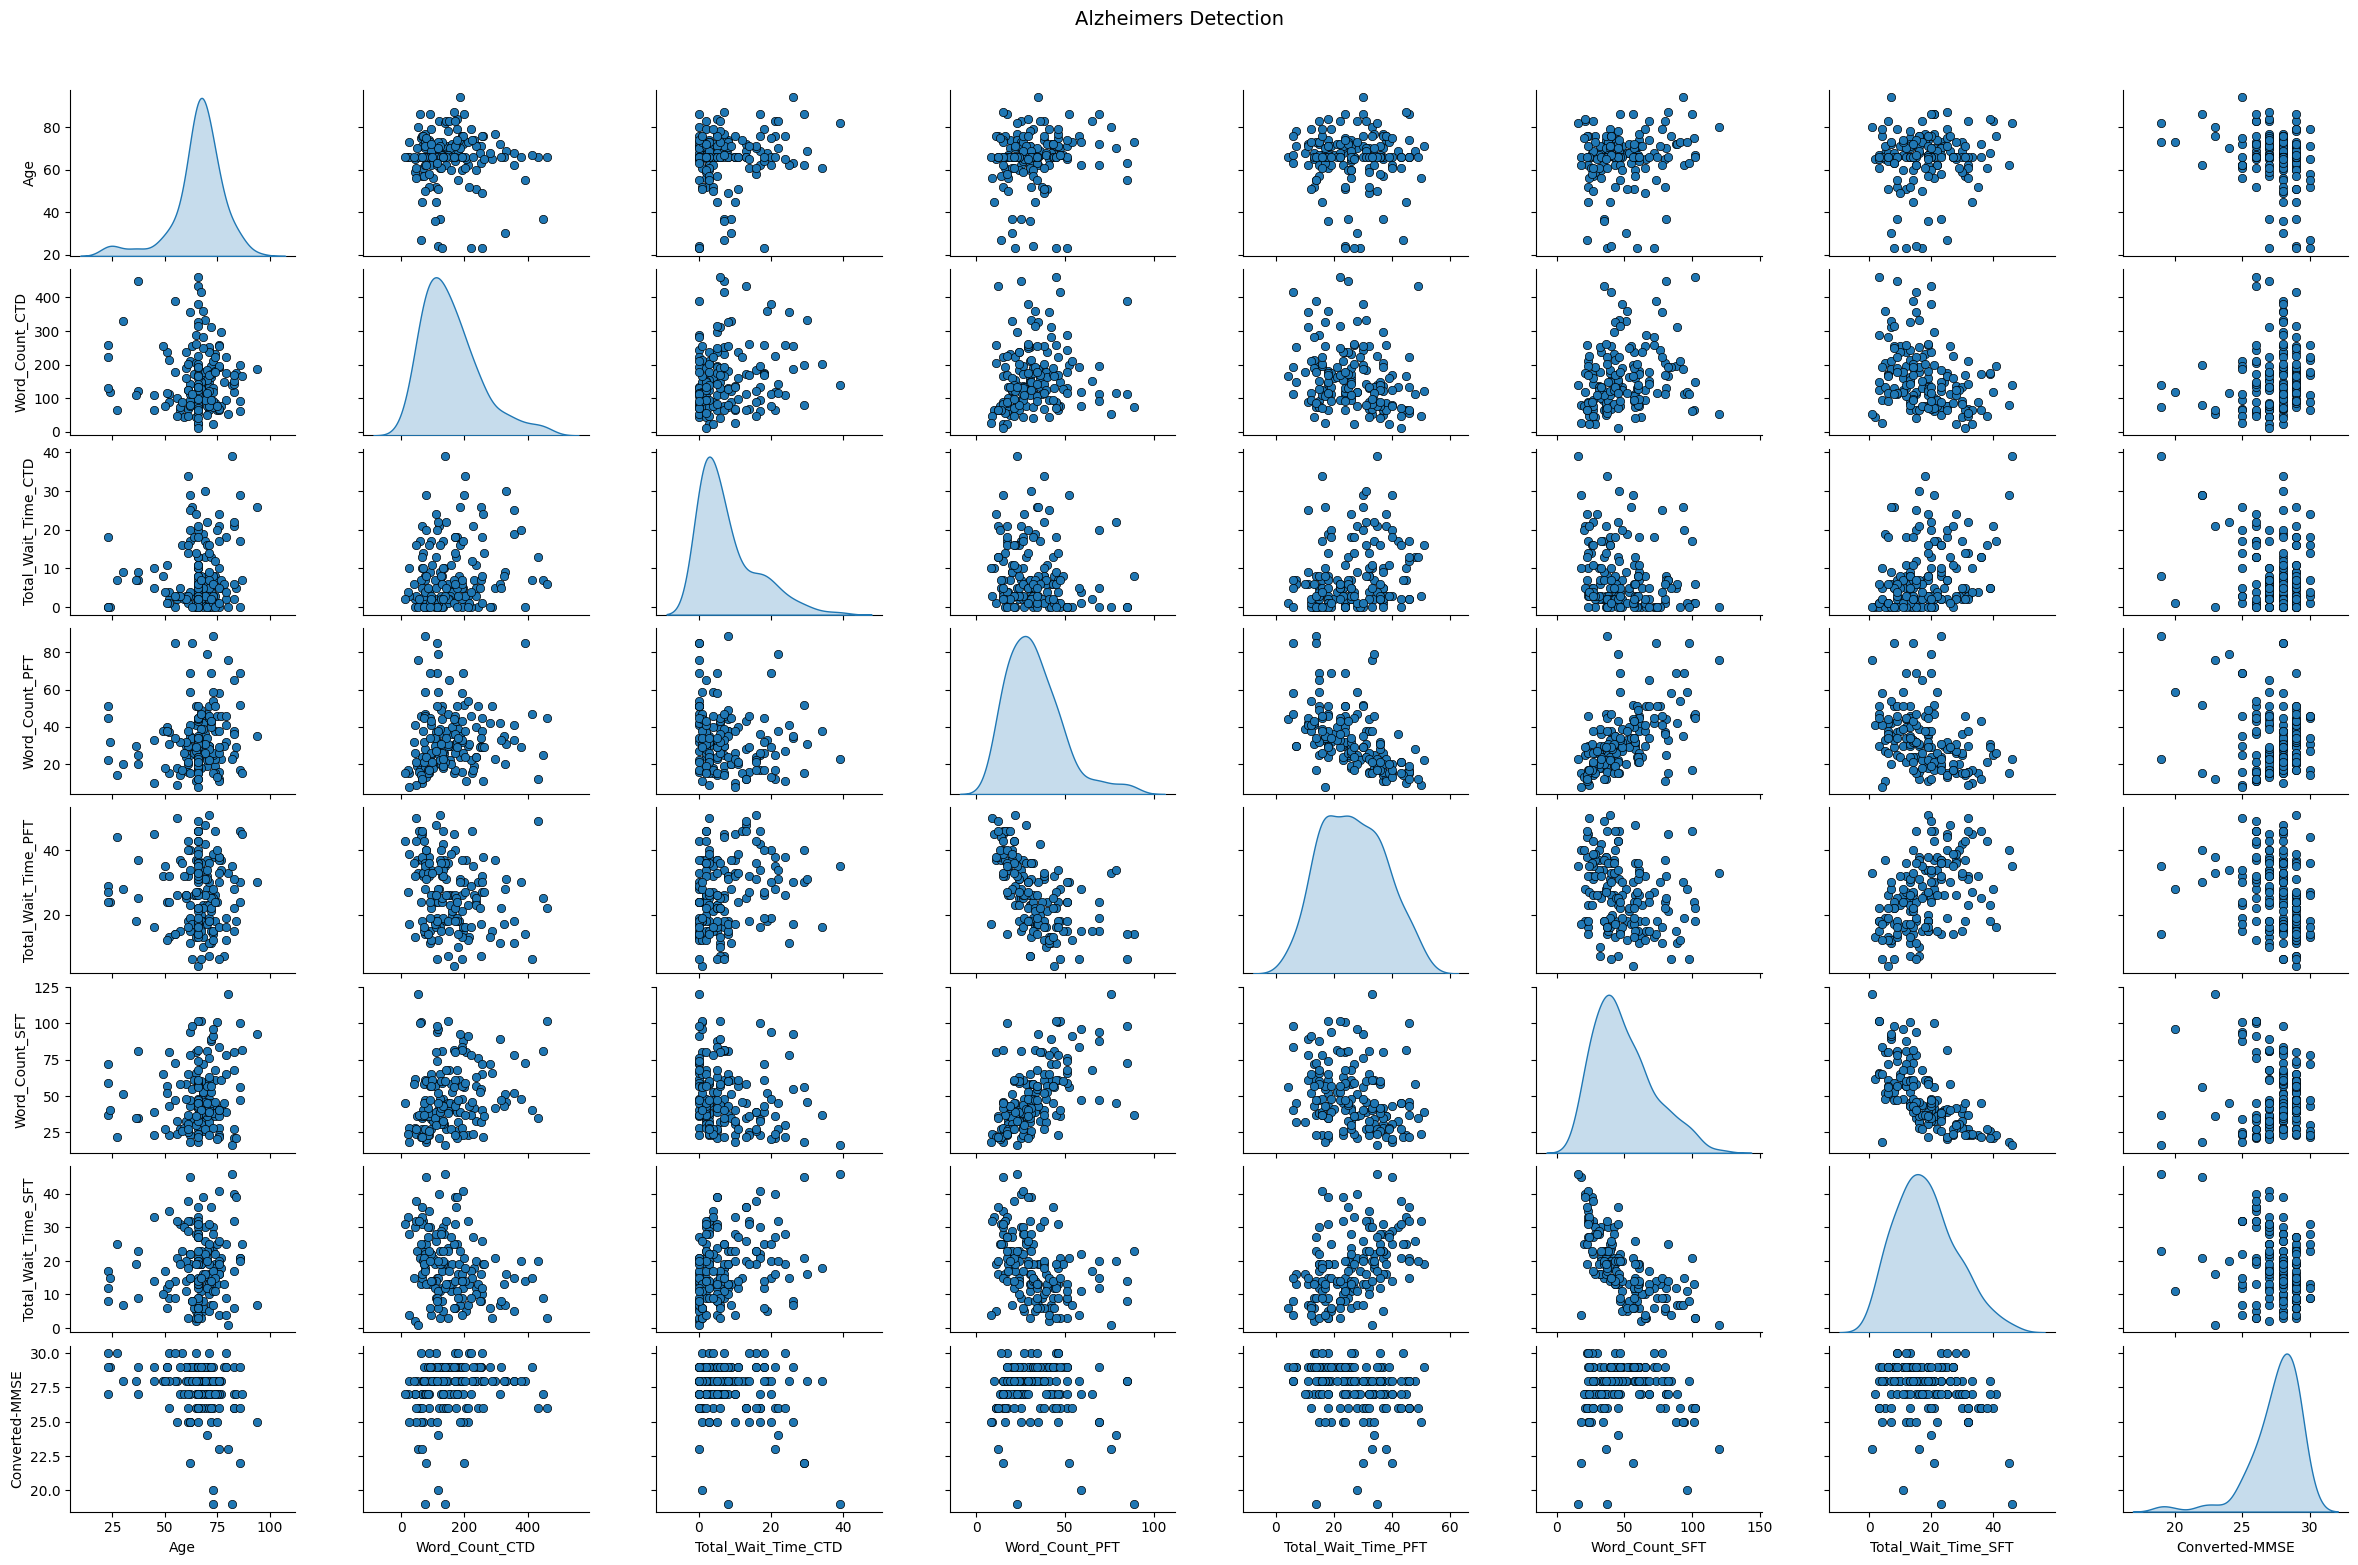

In [10]:
# Pair-wise Scatter Plots
pp = sns.pairplot(df, height = 2, aspect = 1.5, # set height of each facet to 2 inches and width to 2 * 1.5 inches
                  plot_kws = dict(edgecolor = "k", linewidth = .5), # change edges of points to thin black
                  diag_kind = "kde", diag_kws = dict(fill = True)) # set diagonal charts, kws = keyword arguments

fig = pp.fig
fig.subplots_adjust(top = .93, wspace = .3) # increase top space and white spaces between the plots
fig.suptitle('Alzheimers Detection', fontsize = 14); # add title to figure

In [11]:
# Save table with filled values
df.to_csv("Filled_mmse-ML.csv", index = False)